<a href="https://colab.research.google.com/github/MalihaUCF/Autoencoders/blob/master/Autoencoder_PCA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#


#https://drive.google.com/file/d/1gScMvUlgq7czlTCUwWy_-sRMalL1BkQ5/view?usp=sharing

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1gScMvUlgq7czlTCUwWy_-sRMalL1BkQ5'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

    100% |████████████████████████████████| 993kB 20.3MB/s 


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
!ls


adc.json  sample_data


In [2]:
from google.colab import files

uploaded = files.upload()

#for fn in uploaded.keys():
  #print('User uploaded file "{name}" with length {length} bytes'.format(
      #name=fn, length=len(uploaded[fn])))

Saving lfw_attributes.txt to lfw_attributes.txt


In [4]:
from google.colab import files

uploaded = files.upload()

Saving lfw.tgz to lfw.tgz


In [5]:
!ls


lfw_attributes.txt  lfw.tgz  sample_data


In [0]:
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm


ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=True,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs


X shape: (5507, 38, 38, 3)
attr shape: (5507, 73)


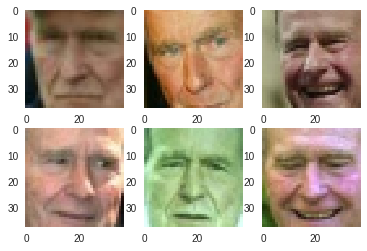

In [26]:
#Import Stuff
import numpy as np
from sklearn.model_selection import train_test_split
#from lfw_dataset import load_lfw_dataset
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()
# Loading and normalizing [Might take some time]
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0
img_shape = X.shape[1:]
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
# Checking out some images
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])
print("X shape:",X.shape)
print("attr shape:",attr.shape)

In [13]:
code_size = 32
pca_autoencoder = keras.models.Sequential()
# Input layer
pca_autoencoder.add(L.InputLayer(img_shape))
# Flattening the layer
pca_autoencoder.add(L.Flatten())
# Encoded space
pca_autoencoder.add(L.Dense(code_size))
# Output units should be image_size * image_size * channels 
pca_autoencoder.add(L.Dense(np.prod(img_shape)))
# Last layer 
pca_autoencoder.add(L.Reshape(img_shape))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
pca_autoencoder.compile('adamax', 'mse')
pca_autoencoder.fit(x=X_train,y=X_train,epochs=10, batch_size=500,
                validation_data=[X_test,X_test])

Instructions for updating:
Use tf.cast instead.
Train on 4956 samples, validate on 551 samples
Epoch 1/10
4956/4956 [==============================] - 1s 218us/step - loss: 0.3091 - val_loss: 0.0961
Epoch 2/10
4956/4956 [==============================] - 0s 38us/step - loss: 0.0503 - val_loss: 0.0364
Epoch 3/10
4956/4956 [==============================] - 0s 39us/step - loss: 0.0321 - val_loss: 0.0290
Epoch 4/10
4956/4956 [==============================] - 0s 37us/step - loss: 0.0264 - val_loss: 0.0240
Epoch 5/10
4956/4956 [==============================] - 0s 38us/step - loss: 0.0236 - val_loss: 0.0224
Epoch 6/10
4956/4956 [==============================] - 0s 38us/step - loss: 0.0228 - val_loss: 0.0220
Epoch 7/10
4956/4956 [==============================] - 0s 37us/step - loss: 0.0226 - val_loss: 0.0219
Epoch 8/10
4956/4956 [==============================] - 0s 39us/step - loss: 0.0224 - val_loss: 0.0218
Epoch 9/10
4956/4956 [==============================] - 0s 39us/step - loss: 0.0

In [17]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder
  
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

  
inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

# Merging the models
autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax','mse')

autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 4956 samples, validate on 551 samples
Epoch 1/32
4956/4956 [==============================] - 1s 165us/step - loss: 0.0423 - val_loss: 0.0215
Epoch 2/32
4956/4956 [==============================] - 1s 130us/step - loss: 0.0216 - val_loss: 0.0204
Epoch 3/32
4956/4956 [==============================] - 1s 132us/step - loss: 0.0200 - val_loss: 0.0188
Epoch 4/32
4956/4956 [==============================] - 1s 133us/step - loss: 0.0182 - val_loss: 0.0172
Epoch 5/32
4956/4956 [==============================] - 1s 130us/step - loss: 0.0167 - val_loss: 0.0160
Epoch 6/32
4956/4956 [==============================] - 1s 134us/step - loss: 0.0154 - val_loss: 0.0149
Epoch 7/32
4956/4956 [==============================] - 1s 131us/step - loss: 0.0143 - val_loss: 0.0138
Epoch 8/32
4956/4956 [==============================] - 1s 132us/step - loss: 0.0134 - val_loss: 0.0129
Epoch 9/32
4956/4956 [==============================] - 1s 135us/step - loss: 0.0126 - val_loss: 0.0122
Epoch 10/32
4956/

Final MSE: 0.006768945923173114


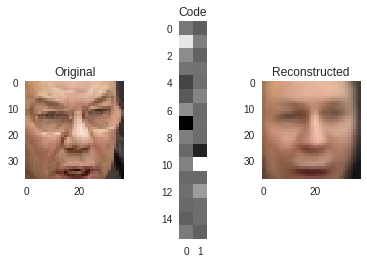

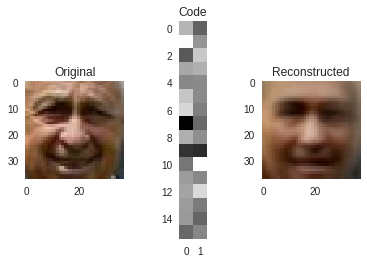

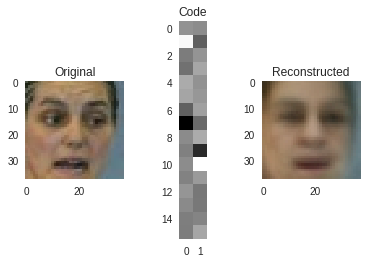

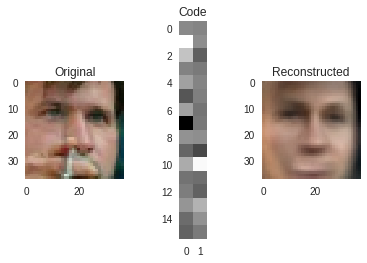

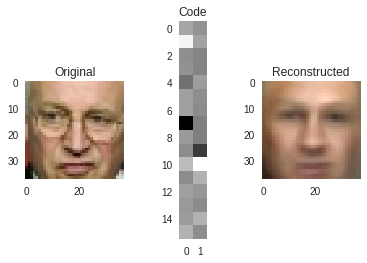

In [25]:
import matplotlib as mpl


def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]
    
    mpl.rcParams['axes.grid'] = False
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()
    
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)